# Duffing equation

Modify Pendulum class to solve the Duffing equation.

* Last revised 03-Feb-2019 by Dick Furnstahl (furnstahl.1@osu.edu).

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.integrate import odeint

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [3]:
# The dpi (dots-per-inch) setting will affect the resolution and how large
#  the plots appear on screen and printed.  So you may want/need to adjust 
#  the figsize when creating the figure.
plt.rcParams['figure.dpi'] = 100.    # this is the default for notebook

# Change the common font size (smaller when higher dpi)
font_size = 10
plt.rcParams.update({'font.size': font_size})

## Duffing equation class and utility functions

In [4]:
class Duffing():
    """
    Duffing class implements the parameters and differential equation for 
     the Duffing equation using the notation from Wikipedia (with _ext added
     for the external force parameters).
     
    Parameters
    ----------
    delta : float
        coefficient of damping term
    alpha : float
        coefficient of linear restoring force
    beta : float
        coefficient of cubic restoring force
    gamma_ext : float
        amplitude of external force is gamma * omega_0**2 
    omega_ext : float
        frequency of external force 

    Methods
    -------
    dy_dt(y, t)
        Returns the right side of the differential equation in vector y, 
        given time t and the corresponding value of y.
    driving_force(t) 
        Returns the value of the external driving force at time t.
    solve_ode(phi_0, phi_dot_0, t_pts)
        Solves the Duffing equation given the initial conditions and an
        array of time points (t_pts).
    """
    def __init__(self, delta=0.3, alpha=-1., beta=+1.,
                 gamma_ext=0.2, omega_ext=1.2
                ):
        self.delta = delta
        self.alpha = alpha
        self.beta = beta
        self.gamma_ext = gamma_ext
        self.omega_ext = omega_ext
    
    def dy_dt(self, y, t):
        """
        This function returns the right-hand side of the diffeq: 
        [dphi/dt d^2phi/dt^2]
        
        Parameters
        ----------
        y : float
            A 2-component vector with y[0] = phi(t) and y[1] = dphi/dt
        t : float
            time 
            
        """
        F_ext = self.driving_force(t)
        return [y[1], -self.delta * y[1] -self.alpha * y[0] \
                      - self.beta * y[0]**3 + F_ext]
    
    def driving_force(self, t):
        """
        This function returns the value of the driving force at time t.
        It uses the convention that the driving term is gamma*cos(omega t).
        """
        return self.gamma_ext * np.cos(self.omega_ext*t)  
    
    def solve_ode(self, phi_0, phi_dot_0, t_pts, 
                  abserr=1.0e-10, relerr=1.0e-10):
        """
        Solve the ODE given initial conditions.
        For now use odeint, but we have the option to switch to solve_ivp.
        Specify smaller abserr and relerr to get more precision.
        """
        y = [phi_0, phi_dot_0]  
        phi, phi_dot = odeint(self.dy_dt, y, t_pts,
                              atol=abserr, rtol=relerr).T
        return phi, phi_dot

In [5]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [6]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    """Return the indices in the array t_pts that are closed to the values
        of plot_start and plot_stop.  We use this for plots versus time
        but it is clearly applies to any array of floats.
    """
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

## Make plots like in Wikipedia

In [7]:
# Labels for individual plot axes
x_vs_time_labels = (r'$t/\tau$', r'$x(t)$')
x_dot_vs_time_labels = (r'$t/\tau$', r'$dx/dt(t)$')
state_space_labels = (r'$x$', r'$dx/dt$')


# Common Duffing parameters for all of the plots
alpha = -1.
beta = +1.
delta = 0.3

omega_ext = 1.2 
tau = 2.*np.pi / omega_ext

# For all plots: same initial conditions
x_0 = 1.
x_dot_0 = 0.0


# Common plotting time in units of the period tau 
#  (generate the largest time we might want then use slices)
t_start = 0.
t_end = 50.*tau
delta_index = 100  # one period in time is delta_index in the array
delta_t = tau / delta_index
t_pts = np.arange(t_start, t_end+delta_t, delta_t)  


# list the gammas in the Wikipedia article
gamma_list = [0.2, 0.28, 0.29, 0.37, 0.50, 0.65]


In [8]:

def plot_figure(gamma_passed, plot_start=0., plot_end=10.):
    gamma_ext = gamma_passed
    duff = Duffing(delta=delta, alpha=alpha, beta=beta,
                   gamma_ext=gamma_ext, omega_ext=omega_ext)
    x, x_dot = duff.solve_ode(x_0, x_dot_0, t_pts,
                              abserr=1.0e-10, relerr=1.0e-10)
    
    start, stop = start_stop_indices(t_pts, plot_start*tau, plot_end*tau) 
    t_pts_plot = t_pts[start : stop]
    x_plot = x[start : stop]
    x_dot_plot = x_dot[start : stop]

    overall_title = 'Duffing oscillator:  ' + \
                    rf' $\gamma = {gamma_ext:.2f},$' + \
                    rf' $\omega = {omega_ext:.1f},$' + \
                    rf' $\alpha = {alpha:.1f},$' + \
                    rf' $\beta = {beta:.1f},$' + \
                    rf' $\delta = {delta:.1f},$' + \
                    rf'  $x_0 = {x_0:.2f},$' + \
                    rf' $\dot x_0 = {x_dot_0:.2f}$' 
                    #'\n'     # \n means a new line (adds some space here)    

    overall_title_no_latex = 'Duffing oscillator:  ' + \
                    rf' gamma = {gamma_ext:.2f},' + \
                    rf' omega = {omega_ext:.1f},' + \
                    rf' alpha = {alpha:.1f},' + \
                    rf' beta = {beta:.1f},' + \
                    rf' delta = {delta:.1f}' + '\n' + \
                    rf'               x_0 = {x_0:.2f},' + \
                    rf' xdot_0 = {x_dot_0:.2f}' + \
                    '\n'     # \n means a new line (adds some space here)    
    
    # print table and also output to a named file
    out_file = open(f'Duffing_gamma_{gamma_ext:.2f}.txt', 'w')
    table_title = '\n\n' + overall_title_no_latex
    print(table_title)
    out_file.write(table_title)
    table_heading = ' t/tau    x(t)     x_dot(t)'
    print(table_heading)
    out_file.write(table_heading + '\n')
    for t, x, xdot in zip(t_pts_plot[::delta_index]/tau, 
                          x_plot[::delta_index], 
                          x_dot_plot[::delta_index]):
        print(f' {t:.2f}  {x: .5f}  {xdot: .5f}')
        out_file.write(f' {t:.2f}  {x: .5f}  {xdot: .5f}\n')
    out_file.close()    
        
    # start the plot!
    fig = plt.figure(figsize=(8,2))
    fig.suptitle(overall_title, va='baseline')
    gs = GridSpec(1,4)
                                          
    # left plot: plot from t/tau=19 to t/tau=38   
    #ax_b = fig.add_subplot(1,2,1)                  
    ax_b = fig.add_subplot(gs[0,0:3])                  
    
    plot_y_vs_x(t_pts_plot/tau, x_plot, 
                axis_labels=x_vs_time_labels, 
                color='blue',
                label=None, 
                title='', 
                ax=ax_b)    
    
    # right plot: state space plot from t/tau 19 to 38  
    #ax_c = fig.add_subplot(1,2,2)                  
    ax_c = fig.add_subplot(gs[0,3])                  
    
    plot_y_vs_x(x_plot, x_dot_plot, 
                axis_labels=state_space_labels, 
                color='blue',
                label=None, 
                title=rf'${plot_start:.0f} \leq t/\tau \leq {plot_end:.0f}$', 
                ax=ax_c) 
    ax_c.plot(x_plot[::delta_index], x_dot_plot[::delta_index],
              'o', color='red')
    ax_c.set_xlim(-1.8, 1.8)
    ax_c.set_ylim(-1.5, 1.5)
    #ax_c.set_aspect(1.)
    
    fig.tight_layout()
    fig.savefig(f'Duffing_gamma_{gamma_ext:.2f}.png', bbox_inches='tight')  




Duffing oscillator:   gamma = 0.20, omega = 1.2, alpha = -1.0, beta = 1.0, delta = 0.3
               x_0 = 1.00, xdot_0 = 0.00

 t/tau    x(t)     x_dot(t)
 19.00   0.56839   0.41273
 20.00   0.56839   0.41273
 21.00   0.56839   0.41273
 22.00   0.56839   0.41273
 23.00   0.56839   0.41273
 24.00   0.56839   0.41273
 25.00   0.56839   0.41273
 26.00   0.56839   0.41273
 27.00   0.56839   0.41273
 28.00   0.56839   0.41273
 29.00   0.56839   0.41273
 30.00   0.56839   0.41273
 31.00   0.56839   0.41273
 32.00   0.56839   0.41273
 33.00   0.56839   0.41273
 34.00   0.56839   0.41273
 35.00   0.56839   0.41273
 36.00   0.56839   0.41273
 37.00   0.56839   0.41273
 38.00   0.56839   0.41273


Duffing oscillator:   gamma = 0.28, omega = 1.2, alpha = -1.0, beta = 1.0, delta = 0.3
               x_0 = 1.00, xdot_0 = 0.00

 t/tau    x(t)     x_dot(t)
 19.00   0.24575   0.23744
 20.00   0.58630   0.38258
 21.00   0.24575   0.23744
 22.00   0.58630   0.38258
 23.00   0.24575   0.23744
 24.00 

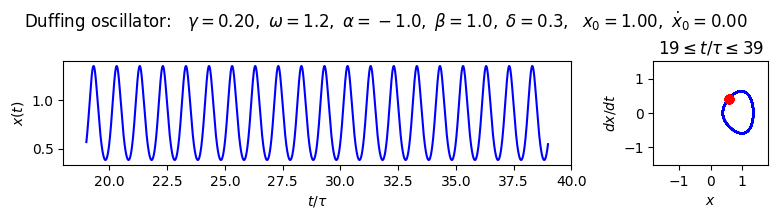

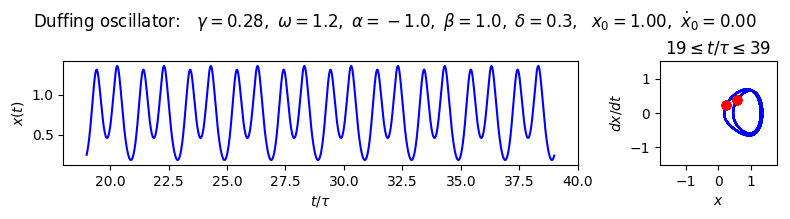

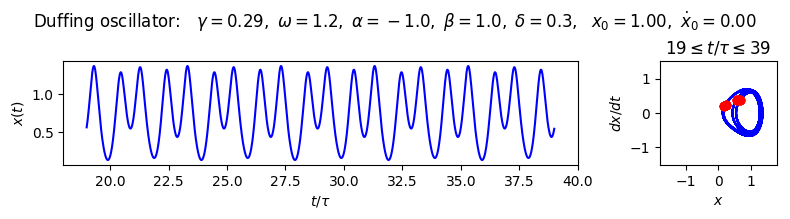

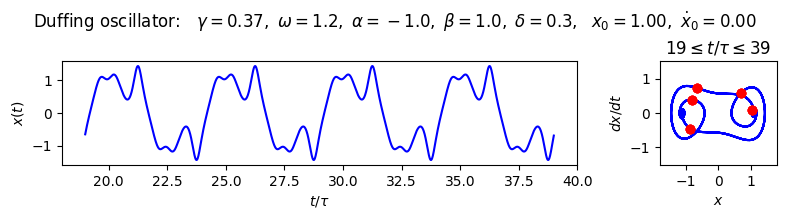

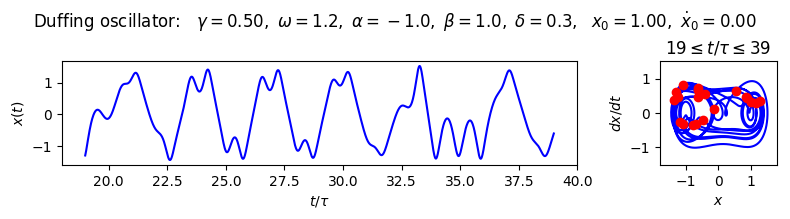

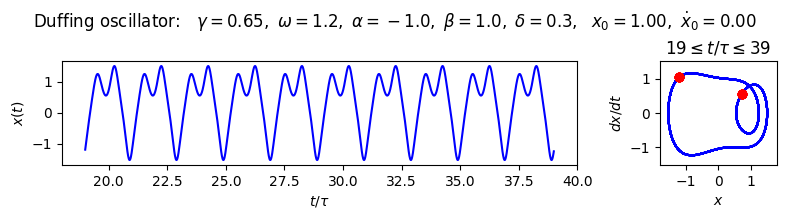

In [9]:
for gamma in gamma_list:
    plot_figure(gamma, 19., 39.)

## Chaos analysis

In [10]:
def plot_long_time_figure(gamma_passed, plot_start=0., plot_end=10.):
    gamma_ext = gamma_passed
    duff = Duffing(delta=delta, alpha=alpha, beta=beta,
                   gamma_ext=gamma_ext, omega_ext=omega_ext)
    x, x_dot = duff.solve_ode(x_0, x_dot_0, t_pts,
                              abserr=1.0e-10, relerr=1.0e-10)
    
    start, stop = start_stop_indices(t_pts, plot_start*tau, plot_end*tau) 
    t_pts_plot = t_pts[start : stop]
    x_plot = x[start : stop]
    x_dot_plot = x_dot[start : stop]

    overall_title = 'Duffing oscillator:  ' + \
                    rf' $\gamma = {gamma_ext:.2f},$' + \
                    rf' $\omega = {omega_ext:.1f},$' + \
                    rf' $\alpha = {alpha:.1f},$' + \
                    rf' $\beta = {beta:.1f},$' + \
                    rf' $\delta = {delta:.1f},$' + \
                    rf'  $x_0 = {x_0:.2f},$' + \
                    rf' $\dot x_0 = {x_dot_0:.2f}$' + \
                    '\n'     # \n means a new line (adds some space here)    

    overall_title_no_latex = 'Duffing oscillator:  ' + \
                    rf' gamma = {gamma_ext:.2f},' + \
                    rf' omega = {omega_ext:.1f},' + \
                    rf' alpha = {alpha:.1f},' + \
                    rf' beta = {beta:.1f},' + \
                    rf' delta = {delta:.1f}' + '\n' + \
                    rf'               x_0 = {x_0:.2f},' + \
                    rf' xdot_0 = {x_dot_0:.2f}' + \
                    '\n'     # \n means a new line (adds some space here)    
    
    # print table and also output to a named file
    out_file = open(f'Duffing_gamma_{gamma_ext:.2f}_extended.txt', 'w')
    table_title = '\n\n' + overall_title_no_latex
    print(table_title)
    out_file.write(table_title)
    table_heading = ' t/tau    x(t)     x_dot(t)'
    print(table_heading)
    out_file.write(table_heading + '\n')
    for t, x, xdot in zip(t_pts_plot[::delta_index]/tau, 
                          x_plot[::delta_index], 
                          x_dot_plot[::delta_index]):
        print(f' {t:.2f}  {x: .5f}  {xdot: .5f}')
        out_file.write(f' {t:.2f}  {x: .5f}  {xdot: .5f}\n')
    out_file.close()    
        
    # start the plot!
    fig = plt.figure(figsize=(8,2))
    fig.suptitle(overall_title, va='baseline')
    gs = GridSpec(1,4)
                                          
    # left plot: plot from t/tau=19 to t/tau=38   
    #ax_b = fig.add_subplot(1,2,1)                  
    ax_b = fig.add_subplot(gs[0,0:3])                  
    
    plot_y_vs_x(t_pts_plot/tau, x_plot, 
                axis_labels=x_vs_time_labels, 
                color='blue',
                label=None, 
                title='', 
                ax=ax_b)    
    
    # right plot: state space plot from t/tau 19 to 38  
    #ax_c = fig.add_subplot(1,2,2)                  
    ax_c = fig.add_subplot(gs[0,3])                  
    
    plot_y_vs_x(x_plot, x_dot_plot, 
                axis_labels=state_space_labels, 
                color='blue',
                label=None, 
                title=rf'${plot_start:.0f} \leq t/\tau \leq {plot_end:.0f}$', 
                ax=ax_c) 
    ax_c.plot(x_plot[::delta_index], x_dot_plot[::delta_index],
              'o', color='red')
    ax_c.set_xlim(-1.8, 1.8)
    ax_c.set_ylim(-1.5, 1.5)
    #ax_c.set_aspect(1.)
    
    fig.tight_layout()
    fig.savefig(f'Duffing_gamma_{gamma_ext:.2f}_extended.png', 
                bbox_inches='tight')  




Duffing oscillator:   gamma = 0.50, omega = 1.2, alpha = -1.0, beta = 1.0, delta = 0.3
               x_0 = 1.00, xdot_0 = 0.00

 t/tau    x(t)     x_dot(t)
 20.00  -0.12842   0.10555
 21.00   1.15864   0.28307
 22.00  -0.46713  -0.20584
 23.00  -0.40840   0.55186
 24.00   0.87157   0.45531
 25.00  -1.16163  -0.26439
 26.00  -0.60732   0.73076
 27.00   0.90155   0.42307
 28.00  -1.08543  -0.33019
 29.00  -0.60959   0.67232
 30.00   1.02609   0.33355
 31.00  -0.75709  -0.35713
 32.00  -0.62089   0.47945
 33.00   0.54845   0.64329
 34.00  -1.35585   0.36686
 35.00  -1.22298   0.47377
 36.00  -1.07786   0.80213
 37.00   1.29592   0.34424
 38.00  -0.67140  -0.30861
 39.00  -0.58098   0.45752
 40.00   0.87805   0.78226
 41.00  -1.29515   0.66884
 42.00   0.90051   0.79374
 43.00  -1.28855   0.68768
 44.00   1.05009   0.77929
 45.00  -1.30207   0.57778
 46.00  -0.59523  -0.22333
 47.00  -0.49805   0.48762
 48.00   1.19107   0.23740
 49.00  -0.29627  -0.08141
 50.00  -0.45532   0.89238
 51.

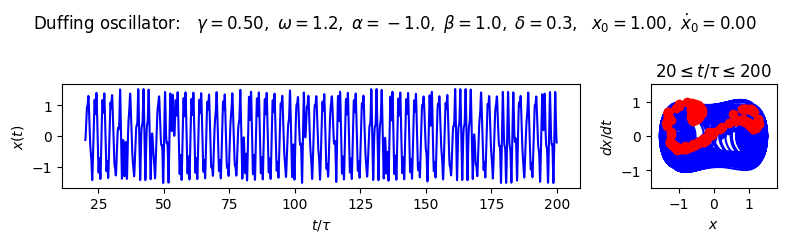

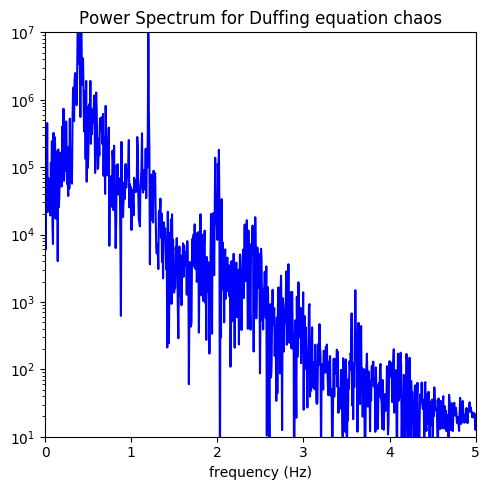

In [11]:
# Common plotting time in units of the period tau 
#  (generate the largest time we might want then use slices)
t_start = 0.
t_end = 200.*tau
delta_index = 100  # one period in time is delta_index in the array
delta_t = tau / delta_index
t_pts = np.arange(t_start, t_end+delta_t, delta_t)  

gamma_chaotic = 0.5

plot_long_time_figure(gamma_chaotic, 20., t_end/tau)

duff = Duffing(delta=delta, alpha=alpha, beta=beta,
                gamma_ext=gamma_chaotic, omega_ext=omega_ext)
x, x_dot = duff.solve_ode(x_0, x_dot_0, t_pts,
                           abserr=1.0e-10, relerr=1.0e-10)


start, stop = start_stop_indices(t_pts, 20., t_end)    
signal = x[start:stop]
power_spectrum = np.abs(np.fft.fft(signal))**2
freqs = 2.*np.pi * np.fft.fftfreq(signal.size, delta_t)
idx = np.argsort(freqs)

fig_ps = plt.figure(figsize=(5,5))
ax_ps = fig_ps.add_subplot(1,1,1)
ax_ps.semilogy(freqs[idx], power_spectrum[idx], color='blue')
ax_ps.set_xlim(0, 5.)
ax_ps.set_ylim(1.e1, 1.e7)
ax_ps.set_xlabel('frequency (Hz)')
ax_ps.set_title('Power Spectrum for Duffing equation chaos')

fig_ps.tight_layout()
fig_ps.savefig(f'Duffing_gamma_{gamma_chaotic:.2f}_power_spectrum.png', 
            bbox_inches='tight')  


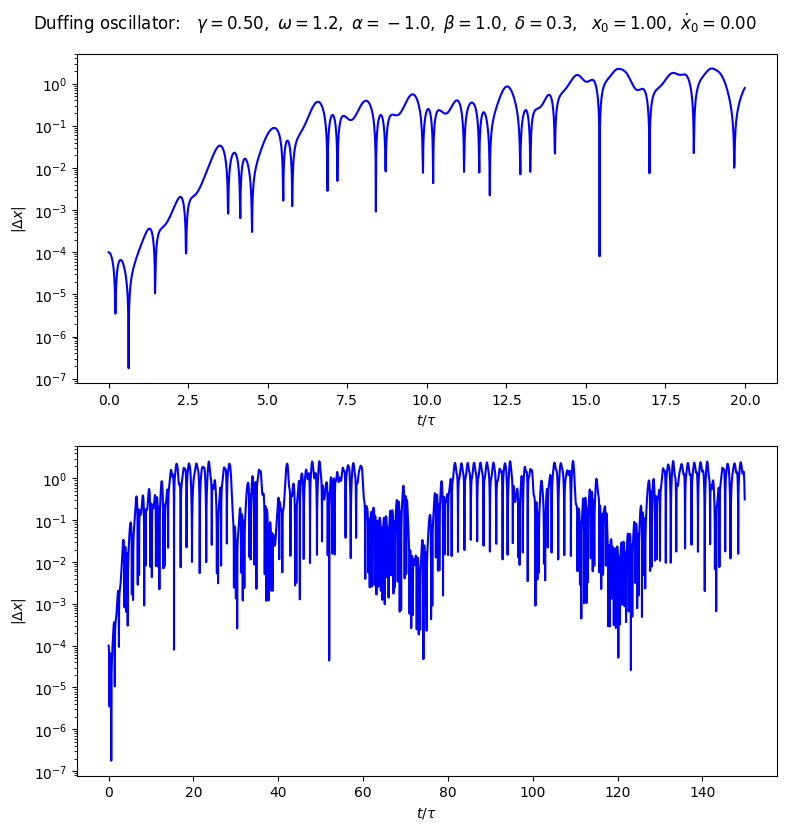

In [12]:
overall_title = 'Duffing oscillator:  ' + \
                    rf' $\gamma = {gamma_chaotic:.2f},$' + \
                    rf' $\omega = {omega_ext:.1f},$' + \
                    rf' $\alpha = {alpha:.1f},$' + \
                    rf' $\beta = {beta:.1f},$' + \
                    rf' $\delta = {delta:.1f},$' + \
                    rf'  $x_0 = {x_0:.2f},$' + \
                    rf' $\dot x_0 = {x_dot_0:.2f}$' + \
                    '\n'     # \n means a new line (adds some space here)    

# make a plot of Delta x for same pendulum but two different initial conds
x_1, x_1_dot = duff.solve_ode(x_0, x_dot_0, t_pts,
                           abserr=1.0e-10, relerr=1.0e-10)
x_2, x_2_dot = duff.solve_ode(x_0 + 1.e-4, x_dot_0, t_pts,
                           abserr=1.0e-10, relerr=1.0e-10)


# Calculate the absolute value of \x_2 - \x_1
Delta_x = np.fabs(x_2 - x_1)

# start the plot!
fig_delta_x = plt.figure(figsize=(8,8))
fig_delta_x.suptitle(overall_title, va='baseline')
    
# two plot: plot from t=0 to t=8 and another from t=0 to t=100 
ax_a = fig_delta_x.add_subplot(2,1,1)                  

start, stop = start_stop_indices(t_pts, 0., 20.*tau)
ax_a.semilogy(t_pts[start : stop]/tau, Delta_x[start : stop], 
            color='blue', label=None)    
ax_a.set_xlabel(r'$t/\tau$')
ax_a.set_ylabel(r'$|\Delta x|$')

ax_b = fig_delta_x.add_subplot(2,1,2)                  

start, stop = start_stop_indices(t_pts, 0., 150.*tau)
plot_y_vs_x(t_pts[start : stop]/tau, Delta_x[start : stop], 
            color='blue', label=None, semilogy=True)    
ax_b.set_xlabel(r'$t/\tau$')
ax_b.set_ylabel(r'$|\Delta x|$')
                              
fig_delta_x.tight_layout()
# always bbox_inches='tight' for best results.  Further adjustments also.
fig_delta_x.savefig(f'Duffing_gamma_{gamma_chaotic:.2f}_Delta_x.png', 
            bbox_inches='tight')  
